In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r'D:/VSCODE code/MTH 522 Code/Project 3/Processed_data.csv')
df.head()

C:\Users\devch\AppData\Local\Temp\ipykernel_15244\400017089.py:1: DtypeWarning: Columns (0,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'D:/VSCODE code/MTH 522 Code/Project 3/Processed_data.csv')


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,STREET,Lat,Long,Location,Tier
0,I152049588,614,LARCENY THEFT FROM MV - NON-ACCESSORY,D4,155.0,0,2015-06-15 00:01:00,2015,6,Monday,0,CONCORD SQ,42.341384,-71.078989,"(42.34138415, -71.07898883)",Tier 3
1,I152049593,1874,DRUGS - OTHER,C11,289.0,0,2015-06-15 00:01:00,2015,6,Monday,0,HANCOCK ST,42.310434,-71.061340,"(42.31043400, -71.06134010)",Tier Drugs
2,I152049594,1874,DRUGS - OTHER,C11,289.0,0,2015-06-15 00:01:00,2015,6,Monday,0,HANCOCK ST,42.310434,-71.061340,"(42.31043400, -71.06134010)",Tier Drugs
3,I152049463,1402,VANDALISM,E18,493.0,0,2015-06-15 00:03:00,2015,6,Monday,0,LEXINGTON AVE,42.262551,-71.115822,"(42.26255067, -71.11582205)",Tier 4
4,I152049469,802,ASSAULT SIMPLE - BATTERY,D14,809.0,0,2015-06-15 00:45:00,2015,6,Monday,0,BAGNAL ST,42.359569,-71.135982,"(42.35956890, -71.13598188)",Tier 2


In [3]:
df['OCCURRED_ON_DATE'] = pd.to_datetime(df['OCCURRED_ON_DATE'],format = 'ISO8601', utc=True)
df['Timestamp'] = pd.to_datetime(df['OCCURRED_ON_DATE'],format = 'ISO8601')

cutoff_date = pd.to_datetime('2023-10-31', utc=True)
cutoff_date2 = pd.to_datetime('2015-07-01', utc=True)

df = df[df['Timestamp']>= cutoff_date2].copy()
df = df[df['Timestamp']<= cutoff_date].copy()

In [4]:
assault_codes =[801,802,803, 423,413, 401,402,411,412,413,421,422,423,424,431,432,433]

assault = df[df['OFFENSE_CODE'].isin(assault_codes)].copy()

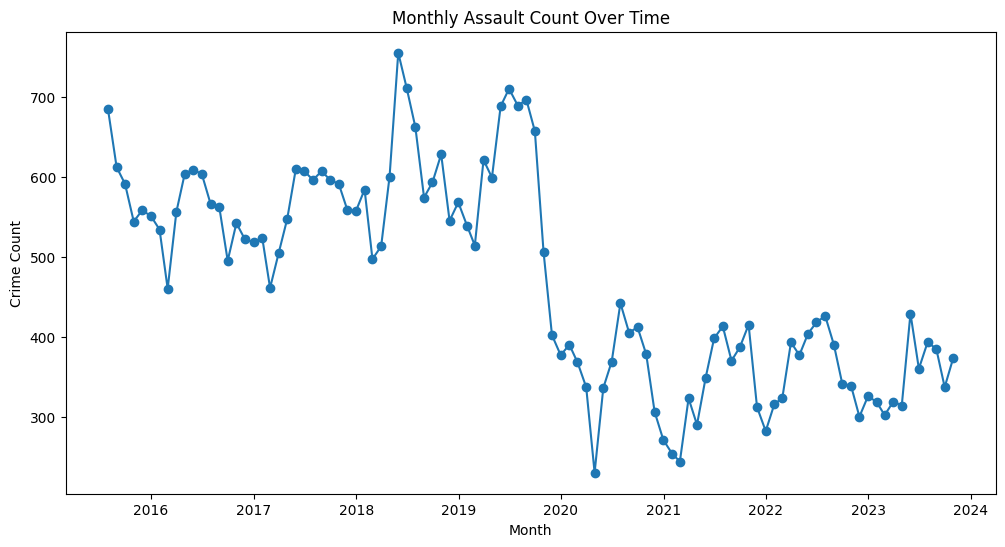

In [5]:
# Assuming your DataFrame is named 'crime_df'
assault['Timestamp'] = pd.to_datetime(assault['Timestamp'], utc = True)
monthly_assault_count = assault.resample('M', on='Timestamp').size()

plt.figure(figsize=(12, 6))
plt.plot(monthly_assault_count, marker='o')
plt.title('Monthly Assault Count Over Time')
plt.xlabel('Month')
plt.ylabel('Crime Count')
plt.show()

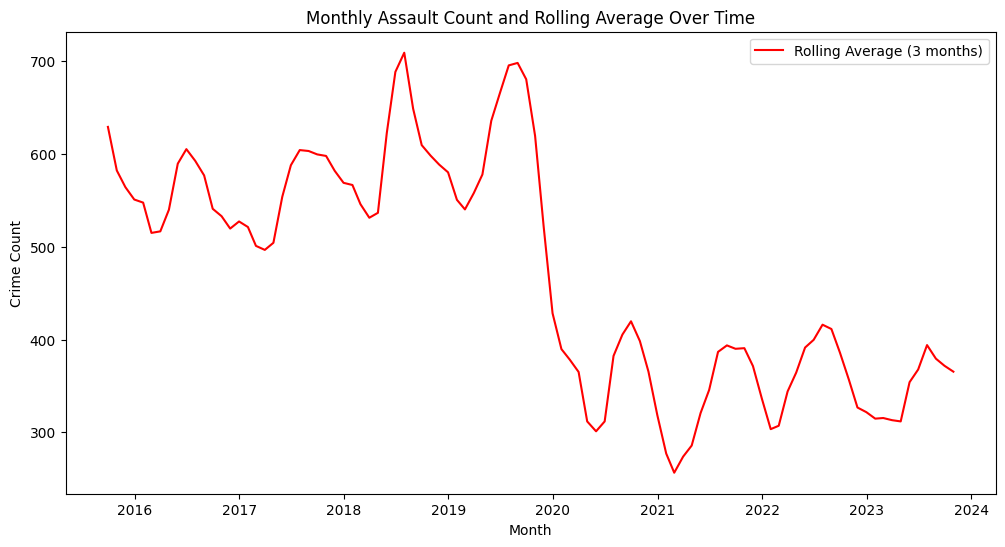

In [6]:
#Rolling average over a 3 month period

rolling_avg = monthly_assault_count.rolling(window=3).mean()

# Plot the monthly accident count and the rolling average
plt.figure(figsize=(12, 6))
#plt.plot(monthly_accident_count, marker='o', label='Monthly Count')
plt.plot(rolling_avg, color='red', label='Rolling Average (3 months)')
plt.title('Monthly Assault Count and Rolling Average Over Time')
plt.xlabel('Month')
plt.ylabel('Crime Count')
plt.legend()
plt.show()

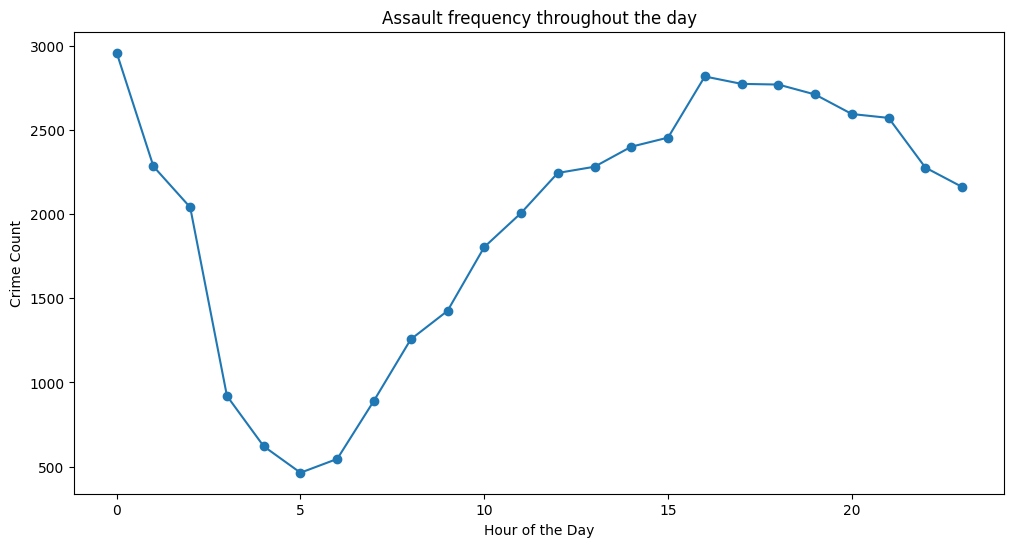

In [16]:
hourly_assault_count = assault.groupby('HOUR').size()

plt.figure(figsize=(12, 6))
plt.plot(hourly_assault_count, marker='o')
plt.title('Assault frequency throughout the day')
plt.xlabel('Hour of the Day')
plt.ylabel('Crime Count')
plt.show()

---

## Models

### Exponential SMoothing

In [7]:
train_size = int(len(monthly_assault_count) * 0.9)
train1, test1 = monthly_assault_count[:train_size], monthly_assault_count[train_size:]

In [8]:
# Exponential smoothing state space model
from statsmodels.tsa.holtwinters import ExponentialSmoothing

ets_model = ExponentialSmoothing(train1, seasonal='add', seasonal_periods=12)
fitted_ets_model = ets_model.fit()
predictions_ets = fitted_ets_model.predict(start=len(train1), end=len(train1) + len(test1) - 1)

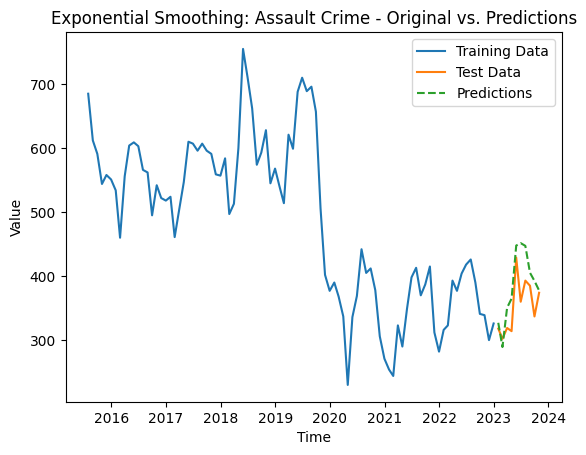

In [9]:
# Plotting the original time series
plt.plot(train1, label='Training Data')
plt.plot(test1, label='Test Data', linestyle='-')

# Plotting the predictions
plt.plot(predictions_ets, label='Predictions', linestyle='--')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Exponential Smoothing: Assault Crime - Original vs. Predictions')

# Displaying the legend
plt.legend()

# Show the plot
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test1, predictions_ets)
rmse = np.sqrt(mse)

print(f"Mean Squared error: {mse}")
print(f"Root mean squared error: {rmse}")

Mean Squared error: 1901.1914392032672
Root mean squared error: 43.60265403852462


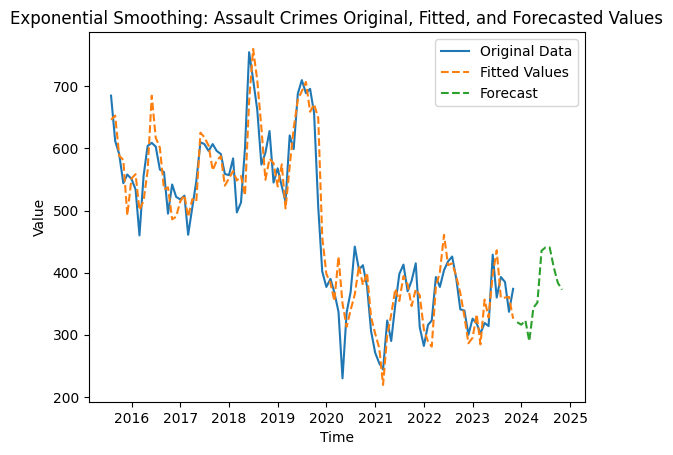

In [11]:
# Set the training size
train_size = int(len(monthly_assault_count) )
train2 = monthly_assault_count[:train_size]

# Exponential smoothing state space model
ets_model = ExponentialSmoothing(train2, seasonal='add', seasonal_periods=12)
fitted_ets_model = ets_model.fit()

# Forecast into the future
forecast_steps = 12  # Set the number of steps to forecast into the future
forecast = fitted_ets_model.forecast(steps=forecast_steps)

# Plotting the original time series
plt.plot(monthly_assault_count, label='Original Data')

# Plotting the fitted values
plt.plot(fitted_ets_model.fittedvalues, label='Fitted Values', linestyle='--')

# Plotting the forecasted values
plt.plot(
    pd.date_range(start=monthly_assault_count.index[-1], periods=forecast_steps + 1, freq='M')[1:],
    forecast,
    label='Forecast',
    linestyle='--'
)

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Exponential Smoothing: Assault Crimes Original, Fitted, and Forecasted Values')

# Displaying the legend
plt.legend()

# Show the plot
plt.show()

---

### Seasonal Decomposition

In [12]:
#Seasonal decomposition of time series data
from statsmodels.tsa.seasonal import STL

stl_model = STL(train1, seasonal=13)
stl_result = stl_model.fit()
seasonal, trend, resid = stl_result.seasonal, stl_result.trend, stl_result.resid


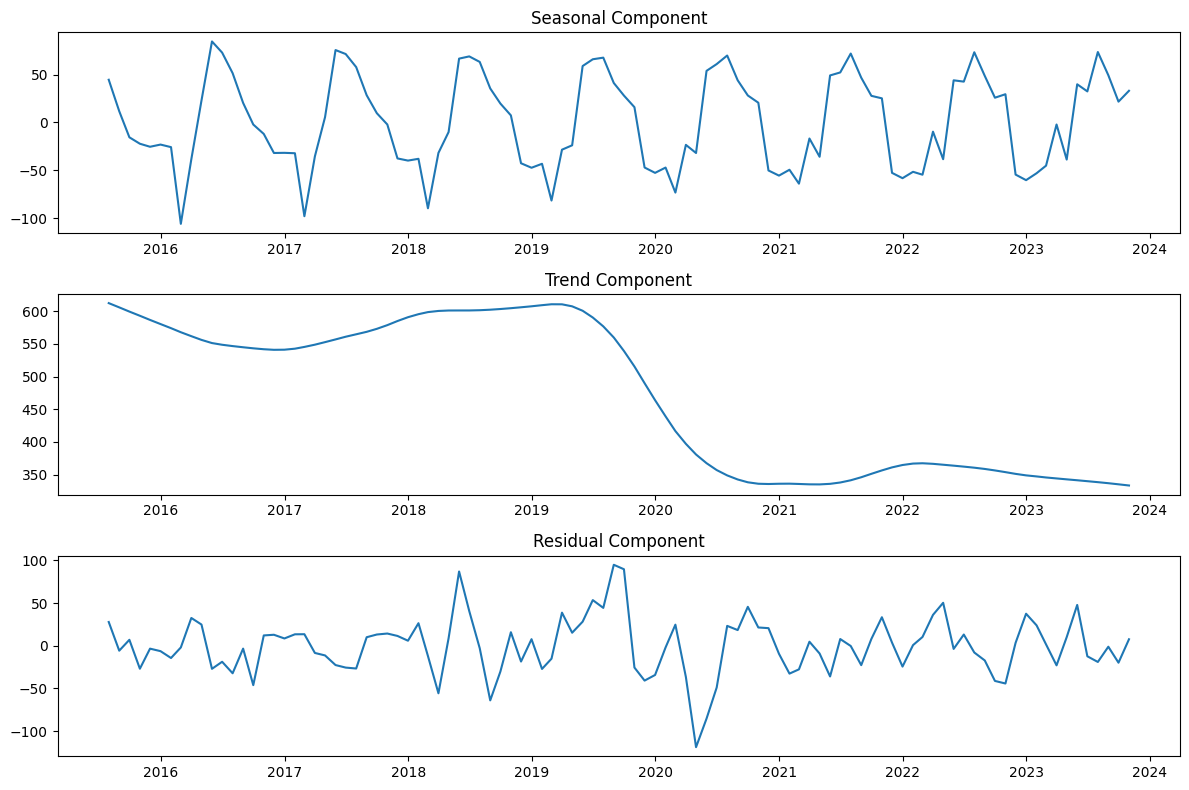

In [13]:
# Seasonal decomposition of time series data
stl_model = STL(train2, seasonal=13)
stl_result = stl_model.fit()
seasonal, trend, resid = stl_result.seasonal, stl_result.trend, stl_result.resid

# Plotting the components separately
plt.figure(figsize=(12, 8))

# Plotting the seasonal component
plt.subplot(3, 1, 1)
plt.plot(seasonal)
plt.title('Seasonal Component')

# Plotting the trend component
plt.subplot(3, 1, 2)
plt.plot(trend)
plt.title('Trend Component')

# Plotting the residual component
plt.subplot(3, 1, 3)
plt.plot(resid)
plt.title('Residual Component')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

---

## SARIMAX

c:\Users\devch\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


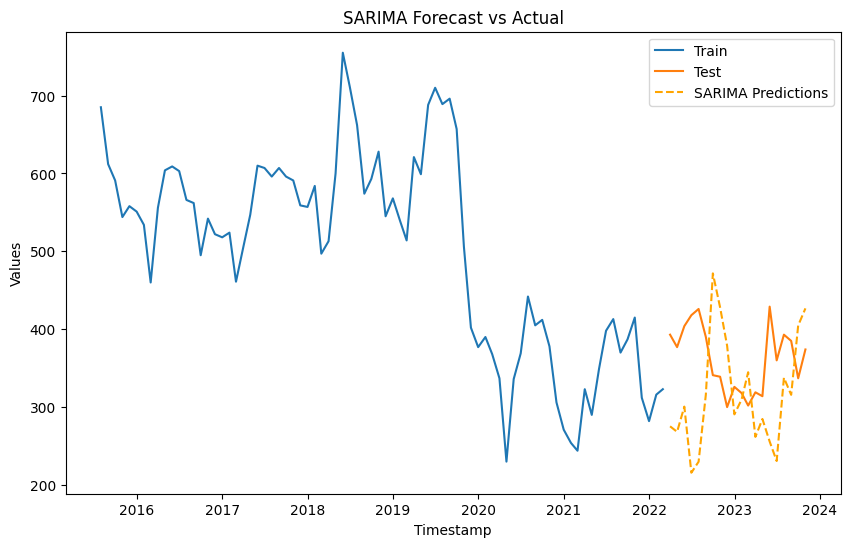

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Split the time series into training and test sets
train_size = int(len(monthly_assault_count) * 0.8)
train, test = monthly_assault_count[:train_size], monthly_assault_count[train_size:]

# Define and fit the SARIMA model
order = (2, 1, 2)  # Replace with your chosen order (p, d, q)
seasonal_order = (2, 1, 2, 52)  # Replace with your chosen seasonal order (P, D, Q, m)
model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
result = model.fit()

# Make predictions on the test set
predictions = result.get_forecast(steps=len(test))
predicted_mean = predictions.predicted_mean

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predicted_mean, label='SARIMA Predictions', linestyle='--', color='orange')
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.legend()
plt.show()